In [2]:
import matplotlib
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, h5py as h5
from matplotlib.cm import rainbow
from PreFRBLE.convenience import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.plot import *


# Rodrigues model for host and intervening galaxies (Rodrigues et al. 2016 & 2018)


Rodrigues et al. provide a set of axisymmetric galaxy ensembles, obtained via GALFORM, which represent the population of galaxies in the Universe according to galaxy formation theory.
From these, we obtain the expected contribution to DM, RM and SM of FRBs via a Monte-Carlo simulation, probing LoS with random geometry through random galaxy models.
Here we translate the output of the Monte-Carlo simulation performed with magnetizer code by Luiz F. S. Rodrigues to format used in PrEFRBLE.
These results are given for different redshift bins than used in PrEFRBLE.
We obtain the likelihood functions used in PrEFRBLE by redshifting the results of the nearest neighbour redshift.

In [40]:
## model nmnemonic
model = 'Rodrigues18'

## file containing raw data
Rodrigues_datafile = '../../likelihood/Rodrigues_galaxy_raw.h5'

## file to contain average r_gal and n_gal
Rodrigues_file_rgal = '../../likelihood/Rodrigues_galaxy_radius.h5'


## number of redshift bins and bins in likelihood functions
N_z, N_bins = 60, 100  

## redshift bins in PreFRBLE
zs0 = redshift_bins

In [ ]:
def NearestNeighbor( x=1., xs=np.array([0.,1.,2.]) ):
    """ find nearst neighbor of x in xs """
    #print( np.diff( xs, axis=1, prepend=x) )
    dx = (xs - x)**2
    i_NN = np.where( dx == dx.min() )[0][0]
    return i_NN

def NearestNeighbors( x=1., xs=np.array([0.,1.,2.]) ):
    """ find nearst neighbors of x in xs """
    try:
        i_NN = np.where( xs >= x )[0][0]
    except:
        return np.array([-1])
    return np.array([-1,0]) + i_NN


def  LikelihoodStandardize( P=[], x=[], redshift=0.0, measure='DM' ):
    """ transform raw data format to standard format in PrEFRBLE """
        
    ## translate logarithmic bin central points to bin ranges
    dx = np.mean(np.diff(x))
    x = 10.**np.append( x[0]-dx/2, x+dx/2 )

    ## raw data is normalized to 1 = sum( P * diff( log10(DM) ) ), renormalize to 1 = sum( P * diff(DM) )
    P *= np.diff( np.log10(x) ) / np.diff( x )
    P /= np.sum( P*np.diff(x)) ## make it exact
                
    ## transform to proper values (data is written in residual frame)
    P, x = LikelihoodShift( x=x, P=P, shift=(1+redshift)**-scale_factor_exponent[measure] )
    
    return P, x

In [51]:
n_gals, r_gals = [], []

with h5.File(Rodrigues_datafile,'r') as f:
    
    ## redshift bins of raw results
    zs = list(f.keys())
    zs_float = np.array(zs).astype('float')
    colors = list(Rainbow(zs0))
    for z0, c in zip(zs0, colors):

        ## find nearst neighbour redshift
        iz = NearestNeighbor( x=z0, xs=zs_float )
        
        izs = NearestNeighbors( x=z0, xs=zs_float )
        ## linear approximation
        weights = 1 - np.abs( zs_float[izs] - z0 )/np.diff(zs_float[izs])
        # quadratic approximation
#        weights = 1 - (np.abs( zs_float[izs] - z0 )/np.diff(zs_float[izs]))**2
        if izs[0] == [-1]:
            weights = [1]
    
        
        ## first, prepare correct redshift binning of r_gal and n_gal
        '''
        ### read raw data of nearest neighbour
        r_gal = f['/'.join([zs[iz],"avg_radius"])].value  ## proper
        n_gal = f['/'.join([zs[iz],"number_density"])].value  ## comoving
        '''
        ## instead of nearest neighbour, use approximation between nearest neighbours
        r_gal = np.sum( [ w*f['/'.join([zs[iz],"avg_radius"])].value for iz, w in zip(izs, weights)] )  ## proper
        n_gal = np.sum( [ w*f['/'.join([zs[iz],"number_density"])].value for iz, w in zip(izs, weights)] )  ## proper
        #n_gal = f['/'.join([zs[iz],"number_density"])].value  ## comoving
        #'''
        
        n_gals.append(n_gal)
        r_gals.append(r_gal)

        
        
        for measure in ['DM','RM','SM']:
            for host in [True,False]:
                '''
                ## read raw data of nearest neighbour
                x = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['bins'].value
                P = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['data'].value

                ## bring to standard form used in PrEFRBLE
                P, x = LikelihoodStandardize( P=P, x=x, redshift=z0, measure=measure)
                '''
                ## instead of nearest neighbour, use approximation between nearest neighbours
                
                ## read raw data of nearest neighbours
                Ps, xs = [], []
                for iz in izs:
                    x = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['bins'].value 
                    P = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['data'].value 
                    
                    ## bring to standard form used in PrEFRBLE
                    P, x = LikelihoodStandardize( P=P, x=x, redshift=z0, measure=measure)
                    Ps.append(P)
                    xs.append(x)

                P, x = LikelihoodsAdd( Ps=Ps, xs=xs, log=True, weights=weights, renormalize=1)
                #'''
                
                ## write to file
                if host:
                    keys = [ KeyHost( model=model, redshift=z0, measure=measure, axis=axis ) for axis in ['P','x'] ]
                else:
                    keys = [ KeyInter( model=model, redshift=z0, measure=measure, axis=axis ) for axis in ['P','x'] ]
                Write2h5( likelihood_file_galaxy, datas=[P,x], keys=keys )
        
#        PlotLikelihood( x, P, measure=measure, ax=ax, color=c, alpha=0.5, density=True )
#        plt.xscale('log')
#        plt.yscale('linear')
#        print( 'density?',sum(P*np.diff(x)) )
        #break
#Colorbar( x=zs0, ax=ax,  )

with open( Rodrigues_file_rgal, 'w' ) as f:
    f.write( 'redshift\tr_gal\tn_gal\n' )
    for z, r, n in zip( zs0, r_gals, n_gals):
        f.write( "{0}\t{1}\t{2}\n".format(z,r, n) )

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:30: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:31: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:55: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:56: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


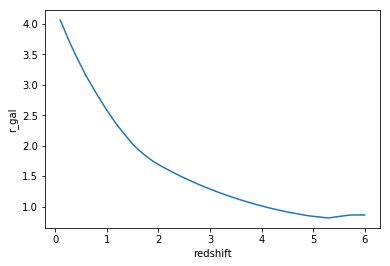

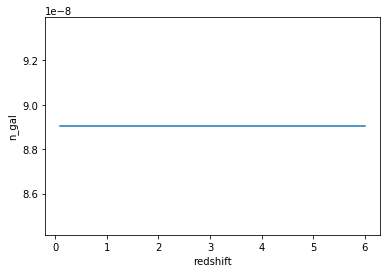

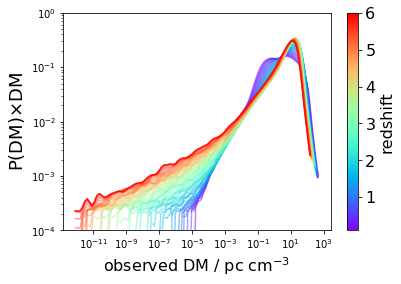

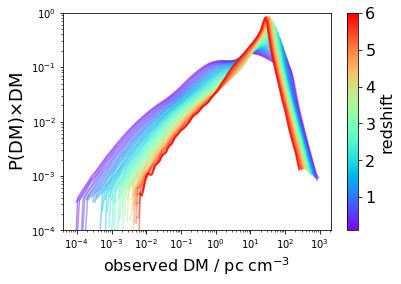

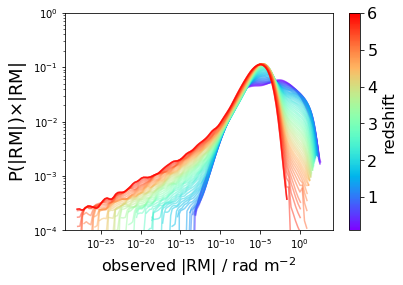

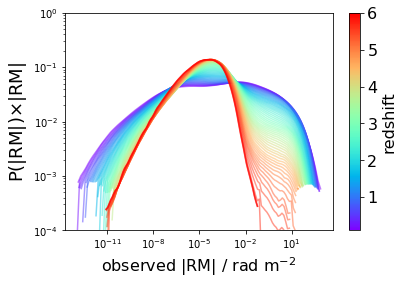

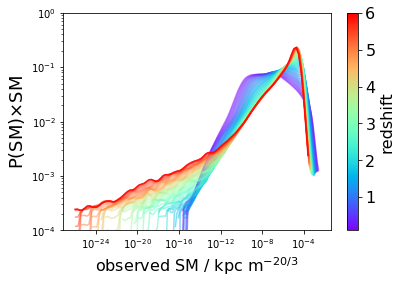

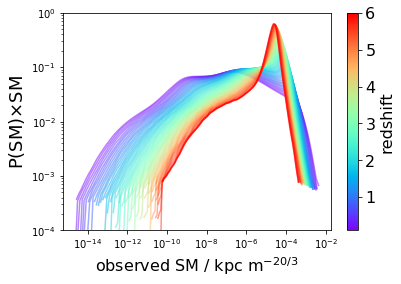

In [75]:
## check results
d = np.genfromtxt(Rodrigues_file_rgal, names=True)
plt.plot( d['redshift'], d['r_gal'])
plt.ylabel('r_gal')
plt.xlabel('redshift')
plt.show()
plt.plot( d['redshift'], d['n_gal'])
plt.ylabel('n_gal')
plt.xlabel('redshift')
plt.show()



for measure in ['DM','RM','SM']:
    for host in [True, False]:
        PlotLikelihoodEvolution( measure=measure, scenario={'Host' if host else 'Inter':['Rodrigues18']}, colorbar=True, density=True, alpha=0.5 )
        plt.ylim(1e-4,1)
        plt.show()
#plt.yscale('linear')

compare with Kierdorf et al.

Text(0.5,1,'M51 observed S-band')

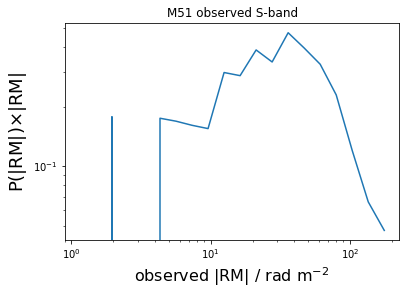

In [22]:
RM_M51 = np.genfromtxt('../../downloads/M51_RM_Sband.txt')
P, x = Histogram( np.abs(RM_M51)[RM_M51 != 0.0], log=True, bins=20, density=True, range=[1,200] )
PlotLikelihood( x, P, measure='RM' )
plt.title( 'M51 observed S-band')



$\text{ Intervening Galaxies}$

combine raw likelihood functions of intervening galaxies in redshift bin to likelihood function of source. This is done by adding probabilities of different bins, weighted by the probability to intersect galaxy in that bin.

0.007158219999999999 0.014084507042253521


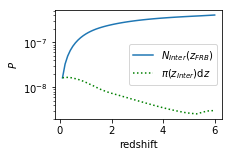

In [58]:
### plot likelihood for galaxies at redshift to intersect LoS, n_inter, which is used to weigh the redshift bins
### as well as expectet number of galaxies in LoS to source, N_inter

fig, ax = plt.subplots( figsize=(3,2) )

## values adopted from Marcquart & Koay 2013
n_gal = 0.02*hubble_constant**3  
r_gal = 0.01/hubble_constant     
print(n_gal, r_gal)

## values corresponding to Rodrigues18 model

n_gal = 8.9e-08  # Mpc-3, comoving

d = np.genfromtxt(Rodrigues_file_rgal, names=True)
r_gal = d['r_gal'] # kpc
n_gal = d['n_gal'] # Mpc-3
comoving=True
redshifts = d['redshift']

## use correct r_gal = 2.7 * r_1/2 and units (Mpc)
r_gal *= 2.7e-3


pi_inter = PriorInter( redshift_bins[-1], r=r_gal, n=n_gal, comoving=comoving )
n_inter = nInter( redshift_bins[-1], r=r_gal, n=n_gal, comoving=comoving )
N_inter = NInter( redshift_bins[-1], r=r_gal, n=n_gal, comoving=comoving )

plt.plot( redshift_bins, N_inter, label=r"$N_{Inter}(z_{FRB})$" )
plt.plot( redshift_bins, n_inter, linestyle=':', label=r"$\pi(z_{Inter})$d$z$", color='green' )
plt.xlabel('redshift')
plt.ylabel(r"$P$")
plt.yscale( 'log')
plt.legend()

weights = n_inter
norms = np.cumsum(weights)
redshift_L = redshift_bins - np.diff(redshift_range)/2


read out raw data of Rodrigues et al. 2018

In [11]:
import pandas as pd
raw_data = pd.read_csv('../likelihood/Rodrigues18_RM_intervening.csv', sep=',',)

#raw_data = np.genfromtxt('../likelihood/Rodrigues18_RM_intervening.csv', delimiter=',', )

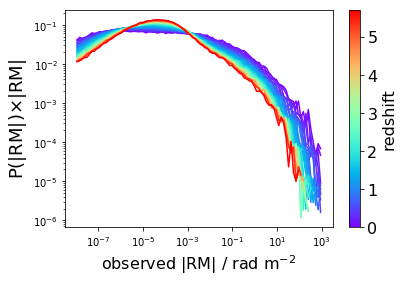

In [73]:

cols = raw_data.columns
redshifts_inter = np.round(cols[1:].astype('f'),2)
xx = 10.**raw_data[cols[0]]     ## central bin values given in raw data file
x = 10.**np.linspace(-8,3,101)  ## corresponding bin ranges
dx = np.diff(x)
fig, ax = plt.subplots()
#fig, axs = plt.subplots(1,2, figsize=(8,3), sharey=True)
#ax=axs[0]
for col, color in zip( cols[1:], Rainbow(redshifts_inter) ):
    P = raw_data[col] #/dx
    pdf = P/dx
    PlotLikelihood( x, pdf, ax=ax, color=color, measure='RM' )
#    axs[1].loglog( xx, P, color=color )
#plt.xlabel( 'RM / %s' % units['RM'])
#plt.ylabel('P')
Colorbar( redshifts_inter, label='redshift')

/data/PreFRBLE/PreFRBLE_venv/lib/python3.4/site-packages/PreFRBLE/convenience.py:118: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5.File( likelihood_file_galaxy ) as f:
/data/PreFRBLE/PreFRBLE_venv/lib/python3.4/site-packages/PreFRBLE/convenience.py:119: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  P = f[ KeyInter( redshift=redshift, model=model, measure=measure, axis='P' ) ].value
/data/PreFRBLE/PreFRBLE_venv/lib/python3.4/site-packages/PreFRBLE/convenience.py:120: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  x = f[ KeyInter( redshift=redshift, model=model, measure=measure, axis='x' ) ].value


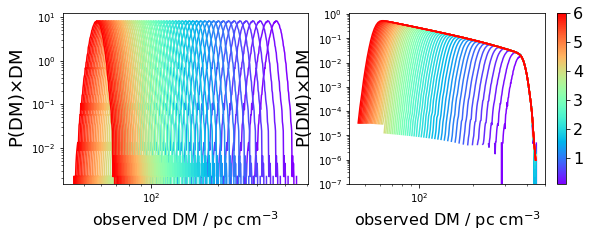

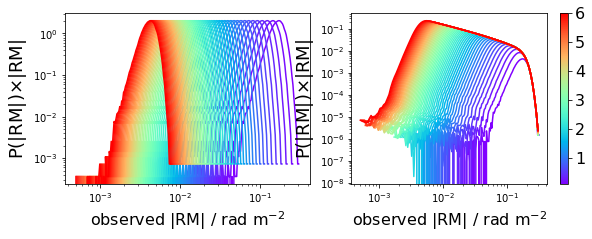

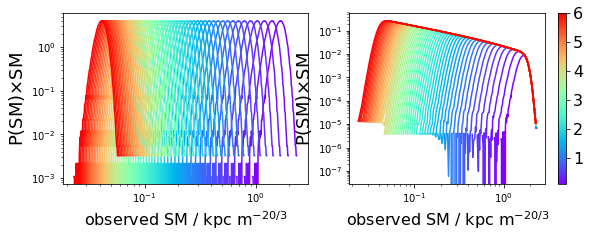

In [6]:
measures = [ 'DM', 'RM', 'SM' ]  ## scattering time needs special treatment in own notebook

fig, axs1 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
fig, axs2 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
fig, axs3 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
axs = [ axs1, axs2, axs3 ]

for measure, axs in zip( measures, axs ):
    for i_s, (z_s, color) in enumerate( zip( redshift_bins, rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
        Ps, xs = [], []
        for i_L , (z_L, color_L) in enumerate( zip( redshift_L[:i_s+1], rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
            ### read raw P(DM_Inter|z_L) for all z_L <= z_s
            P, x = GetLikelihood_Inter( redshift=redshift_bins[i_L], model=model_inter+'/raw', measure=measure)
            if i_s == len(redshift_bins) - 1:
                PlotLikelihood( x, P, measure=measure, color=color_L, ax=axs[0] )
            Ps.append(P)
            xs.append(x)
        ### integrate results for all intervening redshifts, weighing and renormalizing with differential and cumulative intersection probability, respectively
        P, x = LikelihoodsAdd( Ps, xs, weights=weights[:i_s+1], renormalize=norms[i_s] )
        PlotLikelihood( x, P, measure=measure, color=color, ax=axs[1] )
        Write2h5( filename=likelihood_file_galaxy, datas=[P,x], 
                 keys=[ KeyInter( redshift=z_s, model=model_inter, measure=measure, axis=axis) for axis in ['P','x'] ] 
                )

plt.show()


create fake galaxy results for tests

1.0


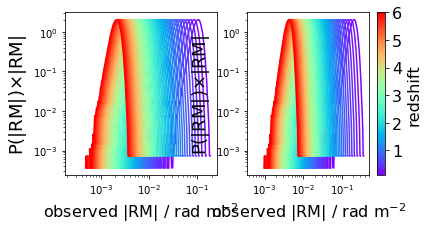

In [12]:
RM_0 = 0.1 # rad m^-2
sigma = 0.2 # log-scaled deviation

#RMs = np.random.lognormal(mean=RM_0, sigma=sigma, size=100000)
RMs = np.random.normal(loc=RM_0, scale=sigma/10, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = Histogram( data=RMs, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='RM', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='RM', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)**2
    x_ = x/(1+z)**2
    PlotLikelihood( x_, P_,  measure='RM', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='RM', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='RM', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='RM', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


1.0


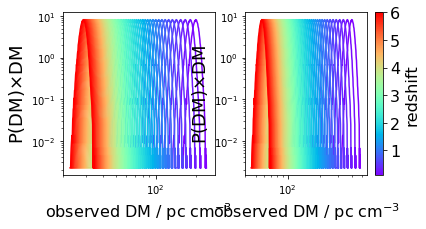

In [13]:
DM_0 = 200 # pc cm^-3
sigma = 10. # log-scaled deviation

DMs = np.random.normal(loc=DM_0, scale=sigma, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = Histogram( data=DMs, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='DM', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='DM', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)
    x_ = x/(1+z)
    PlotLikelihood( x_, P_,  measure='DM', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='DM', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='DM', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='DM', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


1.0


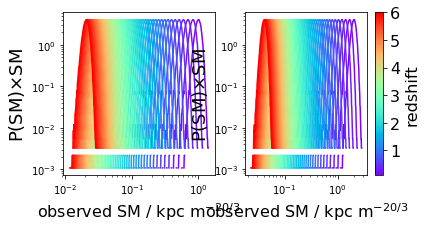

In [14]:
SM_0 = 1 # kpc m^-20/3
sigma = 0.1 # deviation

SMs = np.random.normal(loc=SM_0, scale=sigma, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = Histogram( data=SMs, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='SM', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='SM', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)**2
    x_ = x/(1+z)**2
    PlotLikelihood( x_, P_,  measure='SM', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='SM', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='SM', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='SM', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


1.0


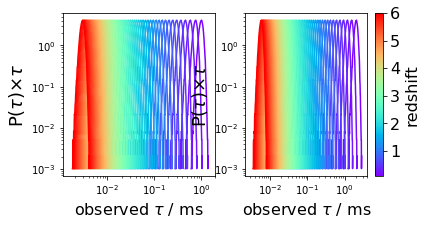

In [15]:
tau_0 = 1 #  ms
sigma = 0.1 # deviation

taus = np.random.normal(loc=tau_0, scale=sigma, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = Histogram( data=taus, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='tau', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='tau', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)**3
    x_ = x/(1+z)**3
    PlotLikelihood( x_, P_,  measure='tau', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='tau', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='tau', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='tau', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


This following is not needed, since all the info is already incoded in results of Rodrigues et al.

In [2]:
def Schechter( M, M_star=1, phi1=1, alpha1=1, phi2=1, alpha2=1):
    return ( phi1 * ( M / M_star )**alpha1 + phi2 * ( M / M_star )**alpha2 ) * np.exp( -M/M_star ) / M_star

In [3]:
## Best fit parameters from Davidzon et al. 2017, Tab. 1, redshifts are extended to z=0 and z=6
parameters = np.genfromtxt( 'COSMOS2015_Schechter_fit.txt', names=True)
parameters['M_star'] = 10.**parameters['M_star']

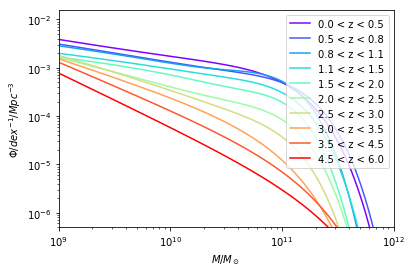

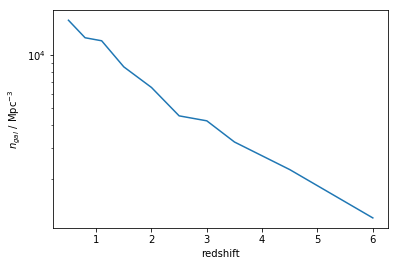

In [17]:
Ms = 10.**np.linspace(9,12,101)
dMs = np.diff(Ms)
n_gal = []
colors = rainbow( np.linspace( 0, 1, len(parameters) ) )
for p, c in zip( parameters, colors ):
    phi = Schechter( Ms, M_star=p['M_star']*1.067, phi1=p['phi1'], alpha1=p['alpha1'], phi2=p['phi2'], alpha2=p['alpha2']) 
    ### correct unit prefactors !!!
    n_gal.append( np.sum( phi[:-1]*dMs ) )
    plt.loglog( Ms[:-1]+dMs/2, phi[:-1]*dMs/110.2, label='%.1f < z < %.1f' % ( p['z0'], p['z1'] ), color=c )
plt.legend()
plt.xlabel('$M/M_\odot$')
plt.ylabel('$\Phi/dex^{-1}/Mpc^{-3}$')
plt.ylim(10.**-6.3, 10.**-1.8)
plt.xlim(1e9, 1e12)
plt.show()

plt.plot( parameters['z1'], n_gal )
plt.ylabel('$n_{gal}$ / Mpc$^{-3}$')
plt.xlabel('redshift')
plt.yscale('log')
plt.show()

In [13]:
len(parameters)


10

In [17]:
import yt
co = yt.utilities.cosmology.Cosmology()
radial_distance = co.comoving_radial_distance